In [1]:
import time
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from   selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait

In [2]:
website = 'https://www.reddit.com/r/MachineLearning/'
  
driver = webdriver.Firefox()

In [3]:
posts = []

for _ in range(50):
    try:
        driver.get(website)
        html = driver.page_source
        bs = BeautifulSoup(html, 'lxml')

        for elem in bs.find('div', {'id':'siteTable'}).findAll('div'):
            if elem.has_attr('id'):
                title = elem.find('p', {'class':'title'}).get_text()
                typ = None
                for long, short in [['Project', '[P]'], ['Discussion', '[D]'], ['Research', '[R]'], ['News', '[N]']]:
                    if title.startswith(long) or title.startswith(short):
                        typ = short[1]
                post_id = elem['id']
                comments = int(elem['data-comments-count'])
                score = int(elem['data-score'])
                timestamp = int(elem['data-timestamp'])
                url = elem['data-url']
                comment_link = elem.find('ul', {'class':'flat-list buttons'}).find('a')['href']
                posts.append([post_id, title, typ, comments, score, url, comment_link, timestamp])

        website = bs.find('span', {'class':'next-button'}).find('a')['href']
        
    except:
        break
        
driver.close()

In [4]:
df = pd.DataFrame(posts, columns=['Id', 'Title', 'Typ', 'Comments', 'Score', 'URL', 'Link-URL', 'Timestamp']).drop_duplicates()
print(df.shape)
df.head(2)

(473, 8)


,Id,Title,Typ,Comments,Score,URL,Link-URL,Timestamp
0,thing_t3_8aluhs,Discussion[D] Machine Learning - WAYR (What Ar...,D,21,65,/r/MachineLearning/comments/8aluhs/d_machine_l...,https://www.reddit.com/r/MachineLearning/comme...,1523141888000
1,thing_t3_8ej2j4,Discussion[D] Facebook Visdom vs Google Tensor...,D,9,17,/r/MachineLearning/comments/8ej2j4/d_facebook_...,https://www.reddit.com/r/MachineLearning/comme...,1524561220000


/home/jm/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


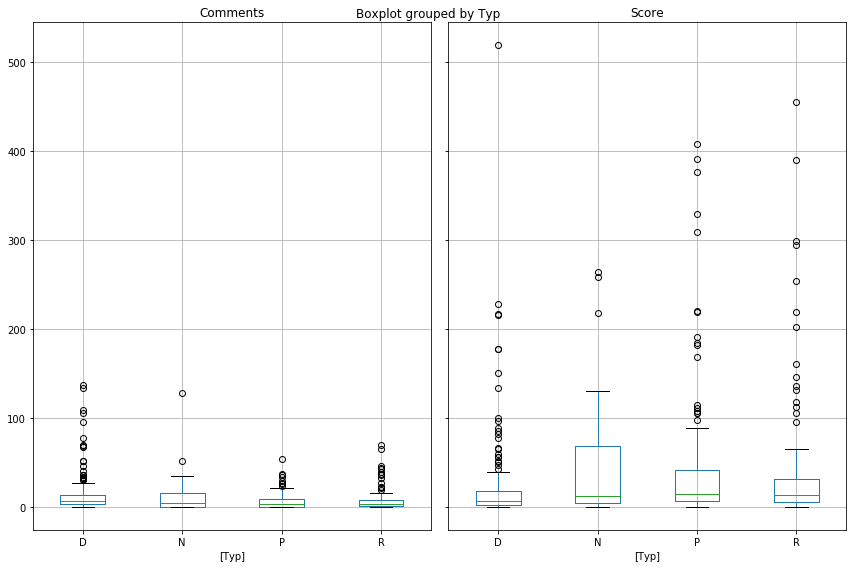

In [5]:
df[['Comments', 'Score', 'Typ']].boxplot(by='Typ', figsize=(12, 8))
plt.tight_layout()
plt.show()

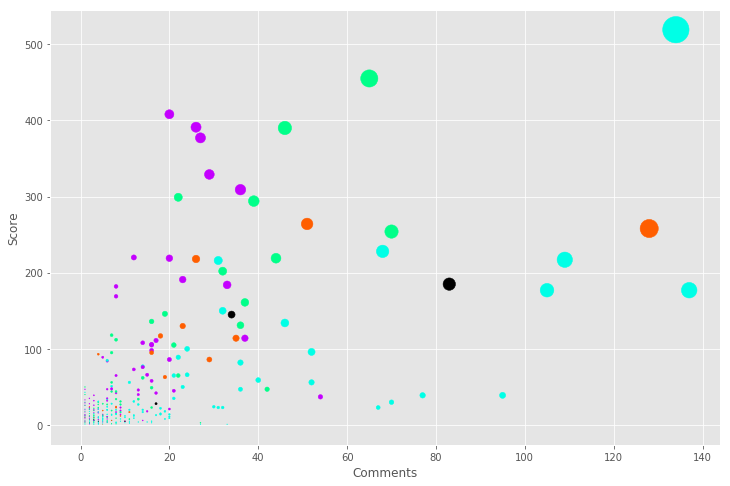

In [6]:
color = {None: (0/255, 0/255, 0/255),
 'D': (0/255, 255/255, 230/255),
 'R': (0/255, 255/255, 137/255),
 'P': (196/255, 0/255, 255/255),
 'N': (255/255, 94/255, 0/255)}

color = {None: '#000000',
 'D': '#00FFE6',
 'R': '#00FF89',
 'P': '#C400FF',
 'N': '#FF5E00'}

plt.style.use('ggplot')
df.plot.scatter(x='Comments', y='Score', figsize=(12, 8), s=df['Comments']*df['Score']/100, c=df.replace({'Typ':color})['Typ'])
plt.legend()
plt.show()

In [7]:
def homepage(x):
    if x.startswith('/'):
        return x.split('/')[2]
    else:
        return x.split('//')[-1].split('/')[0]
    
df['Homepage'] = df['URL'].apply(lambda x: homepage(x))
df['Homepage'].value_counts().head()

MachineLearning    175
github.com          61
arxiv.org           53
medium.com          27
www.youtube.com     14
Name: Homepage, dtype: int64

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

words = {}
for title in df['Title'].values:
    for word in title.split(' '):
        word = word.lower()
        if word not in stop:
            if word in words.keys():
                words[word] += 1
            else:
                words[word] = 1
df_words = pd.DataFrame.from_dict(words, orient='index').rename(columns={0:'Count'})
df_words.sort_values('Count', ascending=False).head(10)

,Count
discussion[d],177
(self.machinelearning),175
project[p],119
learning,102
research[r],99
(github.com),61
(arxiv.org),53
deep,53
machine,50
neural,37


# Download Comments

In [9]:
from multiprocessing.dummy import Pool
import requests
import dateutil
from tqdm import tqdm

def loadComments(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
        html = requests.get(url, headers=headers).text
        bs = BeautifulSoup(html, 'lxml')

        for elem in bs.find('div', {'class':'sitetable nestedlisting'}).findAll('div', {'data-type':'comment'}):
            up_votes = int(elem.find('span', {'class':'score unvoted'}).get_text().split(' ')[0])
            time = dateutil.parser.parse(elem.find('time')['title'], '')
            text = elem.find('div', {'class':'md'}).get_text().strip()
            comments.append([up_votes, time, text, url])
    except:
        pass

In [10]:
pool = Pool(20)
futures = []
comments = []
for url in tqdm(df['Link-URL'].values):
    futures.append(pool.apply_async(loadComments, [url]))
for titel in futures:
    _ = titel.get()

100%|██████████| 473/473 [00:00<00:00, 1512.24it/s]


In [11]:
df_com = pd.DataFrame(comments, columns=['Upvotes', 'Time', 'Text', 'Link-URL']).set_index('Time')
print(df_com.shape)
df_com.head()

(3794, 3)


,Upvotes,Text,Link-URL
Time,,,
2018-04-23 23:15:42+00:00,6,Whatever happened to that Max Planck Institute...,https://www.reddit.com/r/MachineLearning/comme...
2018-04-23 19:34:37+00:00,0,What's very frustrating about these large gove...,https://www.reddit.com/r/MachineLearning/comme...
2018-04-24 02:59:39+00:00,1,I think we can take away money from the life s...,https://www.reddit.com/r/MachineLearning/comme...
2018-04-24 03:14:30+00:00,4,"Cool, but... isn't this kind of unmaintainable...",https://www.reddit.com/r/MachineLearning/comme...
2018-04-24 11:37:04+00:00,2,DeepMimic is what you're looking for.\nAnd her...,https://www.reddit.com/r/MachineLearning/comme...


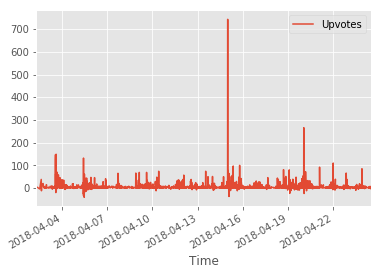

In [12]:
df_com['Upvotes'] = df_com['Upvotes'].astype(int)
import matplotlib.pyplot as plt
df_com.plot()
plt.show()